### Author
 - Gioele Modica

In [ ]:
import os
import numpy as np
from pydicom import dcmread
import matplotlib.pyplot as plt
import highdicom as hd
from ipywidgets import interact, IntSlider
import imageio
from scipy.ndimage import rotate
#TODO:
    # 1. Apply the mask for each view of the 3D volume
    # 3. GIF OF THE 3D VOLUME ROTATE WITH MASK APPLIED

FOLDER_PATH = '1493/30_EQP_Ax5.00mm' 
TUMORAL_SEG_PATH = '1493/30_EQP_Ax5.00mm_ManualROI_Tumor.dcm' 
LIVER_SEG_PATH = '1493/30_EQP_Ax5.00mm_ManualROI_Liver.dcm'

# Functions

In [2]:
def explore_dataset_structure():
    """
    Explore the DICOM dataset structure and print information about found series.
        
    Returns:
        dict: Dictionary containing information about found series
    """
    # Initialize dictionary to store CT series information
    dataset_info = {
        'ct_series': [],
    }
    
    # Traverse the directory tree starting from FOLDER_PATH
    for root, dirs, files in os.walk(FOLDER_PATH):
        for file in files:
            # Check if the file is a DICOM file
            if file.endswith('.dcm'):
                file_path = os.path.join(root, file)
                try:
                    # Read DICOM file without loading pixel data
                    ds = dcmread(file_path, stop_before_pixels=True)
                    
                    # Extract relevant metadata from the DICOM file
                    ct_info = {
                        'path': file_path,
                        'series_description': ds.get('SeriesDescription', ''),
                        'series_instance_uid': ds.get('SeriesInstanceUID', ''),
                        'instance_number': ds.get('InstanceNumber', 0),
                        'acquisition_number': ds.get('AcquisitionNumber', 0)
                    }
                    # Append metadata to the ct_series list
                    dataset_info['ct_series'].append(ct_info)
                except Exception as e:
                    # Handle and report any errors during DICOM file reading
                    print(f"Error reading {file_path}: {str(e)}")
    
    # Print the number of DICOM images found
    print(f"Found {len(dataset_info['ct_series'])} DICOM images")
    
    # Extract and print unique CT series descriptions
    ct_series_descriptions = set([s['series_description'] for s in dataset_info['ct_series']])
    print("\nCT Series Descriptions:")
    for desc in ct_series_descriptions:
        print(f"- {desc}")
    
    # Return the collected dataset information
    return dataset_info


In [3]:
def load_dicom_series():
    """
    Load and sort a DICOM series from a specified folder, ensuring uniform shape.

    Returns:
        list: List of pydicom.Dataset objects sorted
        np.ndarray: 3D volume
    """
    # List of .dcm files in the specified folder
    dicom_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH) if f.endswith('.dcm')]
    
    if not dicom_files:
        raise ValueError(f"No DICOM files found in folder: {FOLDER_PATH}")
    
    slices = []
    for fp in dicom_files:
        try:
            ds = dcmread(fp)
            # Only include files that contain pixel_array
            _ = ds.pixel_array  
            slices.append(ds)
        except Exception as e:
            # Skip and report any unreadable or invalid DICOM files
            print(f"Skipping {fp}: {e}")

    if not slices:
        raise ValueError("No valid CT slices loaded.")

    # Filter slices to retain only those with the same shape as the first one
    ref_shape = slices[0].pixel_array.shape
    uniform_slices = [ds for ds in slices if ds.pixel_array.shape == ref_shape]
    if len(uniform_slices) < len(slices):
        # Warn if non-uniform slices were discarded
        print(f"Warning: scartate {len(slices)-len(uniform_slices)} slice(s) non-conforming.")

    # Separate slices with and without ImagePositionPatient attribute
    with_pos = [ds for ds in uniform_slices if 'ImagePositionPatient' in ds]
    without_pos = [ds for ds in uniform_slices if 'ImagePositionPatient' not in ds]

    # Sort slices using Z coordinate from ImagePositionPatient or by InstanceNumber
    with_pos.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))
    without_pos.sort(key=lambda ds: int(ds.InstanceNumber))

    # Concatenate sorted slices
    sorted_slices = with_pos + without_pos

    # Create 3D volume by stacking pixel arrays
    volume = np.stack([ds.pixel_array for ds in sorted_slices])
    return sorted_slices, volume

In [4]:
def show_dicom_slice(volume, slice_idx, title='DICOM Slice', cmap='gray'):
    """
    Display a single slice from a DICOM volume.
    
    Args:
        volume (numpy.ndarray): 3D DICOM volume
        slice_idx (int): Index of the slice to display
        title (str): Title for the plot
        cmap (str): Colormap to use for display
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(volume[slice_idx], cmap=cmap)
    plt.title(f"{title} - Slice {slice_idx}")
    plt.axis('off')
    plt.show()

In [5]:
def apply_dicom_modality_lut(pixel_array, ds):
    """
    Apply modality LUT to convert pixel values to Hounsfield Units.
    
    Args:
        pixel_array (numpy.ndarray): Raw pixel data
        ds (pydicom.Dataset): DICOM dataset containing required tags
        
    Returns:
        numpy.ndarray: Pixel values in Hounsfield Units
    """
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        return pixel_array * ds.RescaleSlope + ds.RescaleIntercept
    return pixel_array

In [6]:
def load_and_sort_ct_series(directory_path):
    """
    Load and sort a CT series from a directory containing DICOM files.
    
    Args:
        directory_path (str): Path to the directory containing DICOM files of the CT series
        
    Returns:
        list: List of sorted pydicom.Dataset objects
        numpy.ndarray: 3D volume of Hounsfield Units
    """
    # Get list of DICOM files in directory
    dicom_files = [f for f in os.listdir(directory_path) if f.endswith('.dcm')]
    
    # Read all DICOM files (without pixel data first to check headers)
    slices = []
    for filename in dicom_files:
        filepath = os.path.join(directory_path, filename)
        ds = dcmread(filepath, stop_before_pixels=True)
        slices.append(ds)
    
    # Verify this is a CT series
    if not all('ImageType' in ds and 'ORIGINAL' in ds.ImageType for ds in slices):
        print("Warning: Not all slices appear to be original CT images")
    
    # Sort slices based on slice location (ImagePositionPatient)
    slices.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))
    
    # Now load pixel data for sorted slices
    for i, ds in enumerate(slices):
        ds.file_meta = dcmread(os.path.join(directory_path, dicom_files[i])).file_meta
        ds.pixel_array = dcmread(os.path.join(directory_path, dicom_files[i])).pixel_array
    
    # Convert to Hounsfield Units if needed
    volume = np.stack([apply_dicom_modality_lut(ds.pixel_array, ds) for ds in slices])
    
    return slices, volume

In [7]:
def explore_ct_volume(volume):
    """
    Create an interactive widget to explore CT volume slices.
    
    Args:
        volume (numpy.ndarray): 3D CT volume data
    """
    def display_slice(slice_idx):
        plt.figure(figsize=(10, 8))
        plt.imshow(volume[slice_idx], cmap='gray', vmin=-100, vmax=300)  # Typical WW/WL for abdominal CT
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
        plt.show()
    
    interact(display_slice, 
            slice_idx=IntSlider(min=0, max=len(volume)-1, step=1, value=len(volume)//2,
                            layout={'width': '100%'}))

In [8]:
def compute_mip(volume, plane='axial'):
    if plane == 'axial':
        return np.max(volume, axis=0)
    elif plane == 'coronal':
        return np.max(volume, axis=1)
    elif plane == 'sagittal':
        return np.max(volume, axis=2)
    else:
        raise ValueError("Invalid plane")

In [9]:
def show_multiplanar_reconstruction(volume):
    ax_idx = volume.shape[0] // 2
    cor_idx = volume.shape[1] // 2
    sag_idx = volume.shape[2] // 2
    
    compute_mip(volume, 'axial')
    compute_mip(volume, 'coronal')
    compute_mip(volume, 'sagittal')
    # Display the MIP images

    for name, img in [('Axial', volume[ax_idx]),
                        ('Sagittal', volume[:, sag_idx, :].T),
                        ('Coronal', volume[:, :, cor_idx].T)]:
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray', aspect='auto')
        plt.title(f'{name} View')
        plt.axis('off')
        plt.show()


In [10]:
def load_segmentation():
    """
    Load DICOM segmentation file with robust error handling.
    Supports multiple highdicom versions.
    """
    
    try:
        # Read the DICOM SEG file using highdicom
        seg = hd.seg.segread(TUMORAL_SEG_PATH)
        segments_info = []
        
        # Check if the object supports segment_numbers (depends on highdicom version)
        if hasattr(seg, 'segment_numbers'):
            for segment in seg.segment_numbers:
                try:
                    # Try using the public API to extract the mask
                    mask = seg.get_segment_mask(segment)
                except AttributeError:
                    try:
                        # Fallback to internal method if public one is not available
                        mask = seg._get_segment_data(segment)
                    except AttributeError:
                        # Raise an error if no method to get mask is found
                        raise RuntimeError("Could not find segment mask extraction method")
                
                # Get the segment description (e.g., label or meaning)
                description = seg.get_segment_description(segment)
                # Store segment information in a dictionary
                segments_info.append({
                    'number': segment,
                    'description': description,
                    'mask': mask
                })
            return segments_info
        else:
            # Raise an error if segment_numbers attribute is missing
            raise RuntimeError("Unsupported highdicom version - segment_numbers not available")
    except Exception as e:
        # Catch and print any general error during segmentation loading
        print(f"Error loading segmentation: {str(e)}")
        raise


In [11]:
def load_segmentation(path):
    """
    Load a DICOM segmentation by reading pixel_array and SegmentSequence.
    Supports both single and multiple stacked segments.
    """
    # Read the DICOM segmentation file
    ds = dcmread(path) 
    
    # Extract the raw mask array (shape = [frames, rows, cols])
    mask_array = ds.pixel_array  
    
    # Retrieve the list of segments from the DICOM tag SegmentSequence
    seg_seq = ds.get('SegmentSequence', [])
    n_seg = len(seg_seq)
    segments_info = []

    # If there is only one segment, the entire mask_array belongs to it
    if n_seg == 1:
        description = seg_seq[0].get('SegmentDescription', '')
        segments_info.append({
            'number': seg_seq[0].SegmentNumber,
            'description': description,
            'mask': mask_array
        })
    else:
        # Split the frames evenly among the segments
        frames_per_seg = mask_array.shape[0] // n_seg
        for i, seg_item in enumerate(seg_seq):
            # Extract the mask frames corresponding to this segment
            seg_mask = mask_array[i*frames_per_seg : (i+1)*frames_per_seg]
            description = seg_item.get('SegmentDescription', '')  
            segments_info.append({
                'number': seg_item.SegmentNumber,
                'description': description,
                'mask': seg_mask
            })

    # Return list of segment information dictionaries
    return segments_info


In [12]:
def show_segmentation_overlay(ct_slice, mask_slice, title='Segmentation Overlay'):
    """
    Display CT slice with segmentation overlay.

    Args:
        ct_slice (numpy.ndarray): 2D CT slice
        mask_slice (numpy.ndarray): 2D segmentation mask
        title (str): Plot title
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(np.ma.masked_where(mask_slice == 0, mask_slice), 
                cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [13]:
def normalize_image(img):
    """
    Normalize image values to 0-255 for better visualization.

    Args:
        img (numpy.ndarray): Input image

    Returns:
        numpy.ndarray: Normalized image
    """
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)
    return img


In [14]:
def fit_mask_to_volume(mask, volume_shape):
    """
    Fit a 2D mask to the center of a 3D volume shape.
    """
    full_mask = np.zeros(volume_shape, dtype=np.uint8)
    z_start = (volume_shape[0] - mask.shape[0]) // 2
    z_end = z_start + mask.shape[0]
    full_mask[z_start:z_end] = mask
    return full_mask


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.ndimage import rotate

def create_rotating_mip_animation(ct_volume, mask_volume, output_path='rotating_mip.gif'):
    """
    Crea un'animazione GIF che mostra la rotazione 3D del volume CT con le maschere sovrapposte.

    Args:
        ct_volume (numpy.ndarray): Volume CT 3D.
        mask_volume (numpy.ndarray): Volume delle maschere 3D.
        output_path (str): Percorso di salvataggio della GIF.
    """
    frames = []
    angles = np.arange(0, 360, 5)  # Angoli di rotazione

    for angle in angles:
        # Ruota il volume CT e la maschera attorno all'asse z
        rotated_ct = rotate(ct_volume, angle, axes=(1, 2), reshape=False, order=1)
        rotated_mask = rotate(mask_volume, angle, axes=(1, 2), reshape=False, order=0)

        # Calcola la MIP lungo l'asse z
        mip_ct = np.max(rotated_ct, axis=0)
        mip_mask = np.max(rotated_mask, axis=0)

        # Crea l'immagine con la maschera sovrapposta
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(mip_ct.T, cmap='gray', origin='lower')
        ax.imshow(np.ma.masked_where(mip_mask.T == 0, mip_mask.T), cmap='jet', alpha=0.3, origin='lower')
        ax.axis('off')
        plt.tight_layout()

        # Salva il frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close()

    # Salva l'animazione come GIF
    imageio.mimsave(output_path, frames, duration=0.2)
    print(f"Animazione salvata in {output_path}")


In [16]:
def execute():
    """
    Main function to execute the DICOM processing and visualization.
    """
    # Explore dataset structure
    explore_dataset_structure()
    
    # Load CT series
    _, ct_volume = load_dicom_series()

    # Show a slice of the CT volume
    explore_ct_volume(ct_volume)
    
    # Show multiplanar views
    show_multiplanar_reconstruction(ct_volume)
    
    # Load segmentation
    tumor_segments = load_segmentation(TUMORAL_SEG_PATH)

    liver_segments = load_segmentation(LIVER_SEG_PATH)


    all_segments = tumor_segments + liver_segments

    # Create a mask for each segment and combine them
    combined_mask = np.zeros_like(ct_volume, dtype=np.uint8)
    for segment in all_segments:
        full_mask = fit_mask_to_volume(segment['mask'], ct_volume.shape)
        combined_mask = np.logical_or(combined_mask, full_mask)

    # Show the segmentation overlay for each segment
    title = "Segment 1 - Tumor"
    for segment in all_segments:
        segment_mask = fit_mask_to_volume(segment['mask'], ct_volume.shape)
        show_segmentation_overlay(ct_volume[ct_volume.shape[0] // 2], segment_mask[ct_volume.shape[0] // 2], 
                                title=title)
        title = "Segment 2 - Liver"
        

    # Gif animation with all segments combined
    combined_mask = combined_mask.astype(np.uint8)
    create_rotating_mip_animation(ct_volume, combined_mask, output_path='rotating_mip.gif')


# Execution

Found 58 DICOM images

CT Series Descriptions:
- 30_EQP_Ax5.00mm


interactive(children=(IntSlider(value=29, description='slice_idx', layout=Layout(width='100%'), max=57), Outpu…

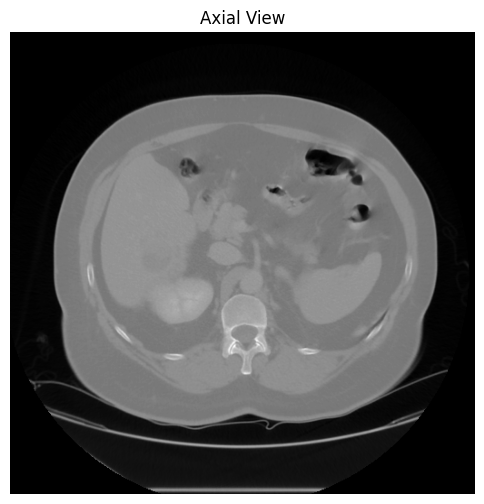

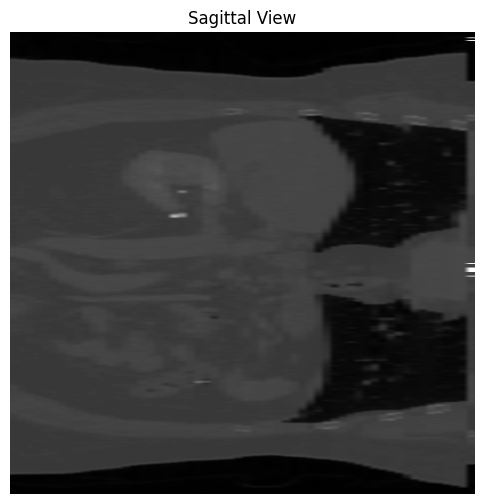

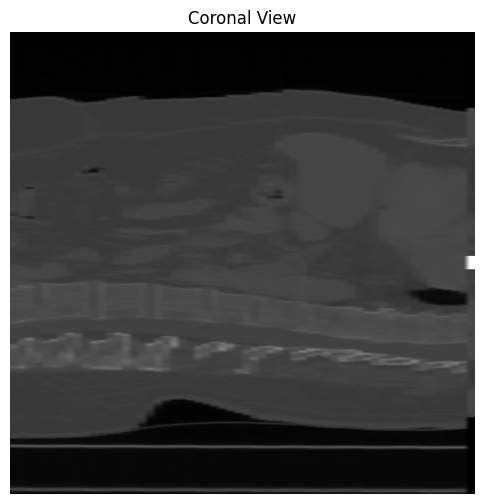

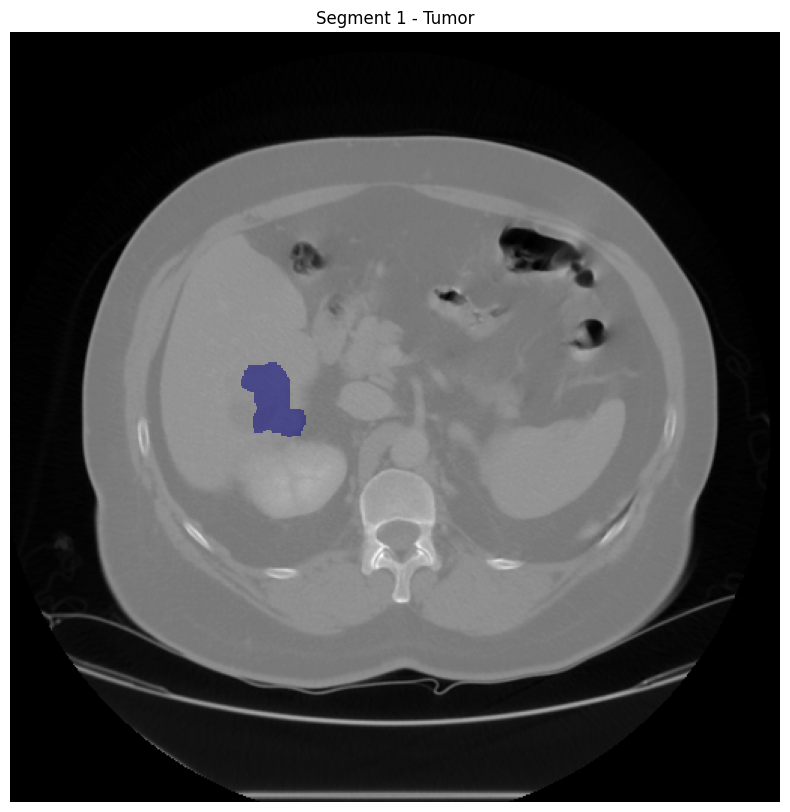

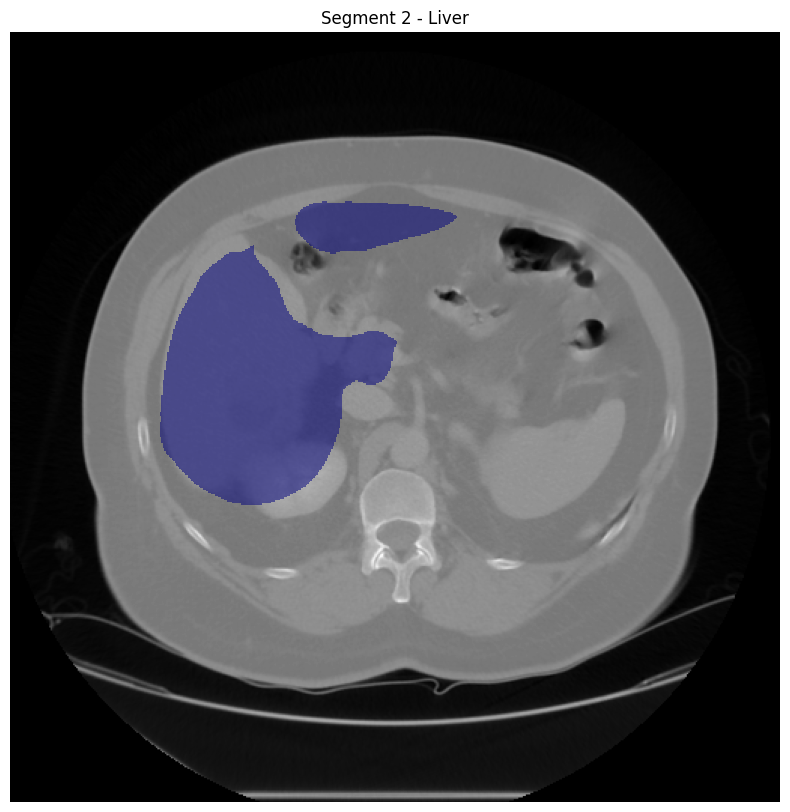

Animazione salvata in rotating_mip.gif


In [17]:
execute()